# A He-burning Network

Here we create a network that can be used as an $\alpha$-chain for modeling He detonations, and includes some of the iron group.  It is similar in goals to the classic `aprox19` network, but it has some additional rates that are important.

In [1]:
import pynucastro as pyna

## Assembling our library

### Core nuclei

We start with a list of nuclei, including all $\alpha$-nuclei up to ${}^{56}\mathrm{Ni}$.
We also add the intermediate nuclei that would participate in $(\alpha,p)(p,\gamma)$ reactions,
as well as a few more nuclei, including those identified by [Shen & Bildsten 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...699.1365S/abstract) for bypassing the ${}^{12}\mathrm{C}(\alpha,\gamma){}^{16}\mathrm{O}$ rate.  These rates are not present in the classic `aprox` networks, but can
be very important for the ignition of a detonation.

In [2]:
nuclei = ["p",
          "he4", "c12", "o16", "ne20", "mg24", "si28", "s32",
          "ar36", "ca40", "ti44", "cr48", "fe52", "ni56",
          "al27", "p31", "cl35", "k39", "sc43", "v47", "mn51", "co55",
          "n13", "n14", "f18", "ne21", "na22", "na23"]

For our initial library, we take all of the ReacLib rates that link these.

In [3]:
reaclib_lib = pyna.ReacLibLibrary()
core_lib = reaclib_lib.linking_nuclei(nuclei)

Since we didn't include neutrons in our list of nuclei, we are missing some potentially important rates, which we now add manually.  However, we do not want to carry neutrons, so we modify the endpoints of these reactions to assume
that the original $(X, n)$ reaction is immediately followed by a neutron capture.

In [4]:
other_rates = [("c12(c12,n)mg23", "mg24"),
               ("o16(o16,n)s31", "s32"),
               ("o16(c12,n)si27", "si28")]

for r, mp in other_rates:
    _r = reaclib_lib.get_rate_by_name(r)
    _r.modify_products(mp)
    core_lib += pyna.Library(rates=[_r])

Now we remove some rates that traditionally are not present in the `aprox`-style networks.  This includes the
reverse rates of ${}^{12}\mathrm{C} + {}^{12}\mathrm{C}$, ${}^{16}\mathrm{O} + {}^{12}\mathrm{C}$, and ${}^{16}\mathrm{O} + {}^{16}\mathrm{O}$.  We also remove some $\alpha$-captures and $p$-captures on neutron-rich nuclei that will be eliminated when we approximate them out of the network.

In [5]:
for r in core_lib.get_rates():
    if sorted(r.products) in [[pyna.Nucleus("c12"), pyna.Nucleus("c12")],
                              [pyna.Nucleus("c12"), pyna.Nucleus("o16")],
                              [pyna.Nucleus("o16"), pyna.Nucleus("o16")]]:
        core_lib.remove_rate(r)

rates_to_remove = ["p31(p,c12)ne20",
                   "si28(a,c12)ne20",
                   "ne20(c12,p)p31",
                   "ne20(c12,a)si28",
                   "na23(a,g)al27",
                   "al27(g,a)na23",
                   "al27(a,g)p31",
                   "p31(g,a)al27"]

for r in rates_to_remove:
    _r = core_lib.get_rate_by_name(r)
    core_lib.remove_rate(_r)

Here's the current list of rates

In [6]:
core_lib

He4 + He4 + He4 ⟶ C12 + 𝛾      [Q =   7.28 MeV] (He4 + He4 + He4 --> C12 <fy05_reaclib__>)
C12 + p ⟶ N13 + 𝛾              [Q =   1.94 MeV] (C12 + p --> N13 <ls09_reaclib__>)
C12 + He4 ⟶ O16 + 𝛾            [Q =   7.16 MeV] (C12 + He4 --> O16 <nac2_reaclib__>)
C12 + C12 ⟶ He4 + Ne20         [Q =   4.62 MeV] (C12 + C12 --> He4 + Ne20 <cf88_reaclib__>)
C12 + C12 ⟶ p + Na23           [Q =   2.24 MeV] (C12 + C12 --> p + Na23 <cf88_reaclib__>)
C12 + C12 ⟶ Mg24 + 𝛾           [Q =  13.93 MeV] (C12 + C12 --> Mg24 <cf88_reaclib__reverse>)
N13 + He4 ⟶ p + O16            [Q =   5.22 MeV] (N13 + He4 --> p + O16 <cf88_reaclib__>)
N14 + He4 ⟶ F18 + 𝛾            [Q =   4.41 MeV] (N14 + He4 --> F18 <il10_reaclib__>)
O16 + He4 ⟶ Ne20 + 𝛾           [Q =   4.73 MeV] (O16 + He4 --> Ne20 <co10_reaclib__>)
O16 + C12 ⟶ He4 + Mg24         [Q =   6.77 MeV] (O16 + C12 --> He4 + Mg24 <cf88_reaclib__>)
O16 + C12 ⟶ p + Al27           [Q =   5.17 MeV] (O16 + C12 --> p + Al27 <cf88_reaclib__>)
O16 + C12 ⟶ Si28 + 𝛾    

### Iron group

Now we'll add some more nuclei in the iron group.

In [7]:
iron_peak = ["n", "p", "he4",
             "mn51",
             "fe52", "fe53", "fe54", "fe55", "fe56",
             "co55", "co56", "co57",
             "ni56", "ni57", "ni58"]

In [8]:
iron_reaclib = reaclib_lib.linking_nuclei(iron_peak)

weak_lib = pyna.TabularLibrary()
iron_weak_lib = weak_lib.linking_nuclei(iron_peak)

In [9]:
all_lib = core_lib + iron_reaclib + iron_weak_lib

## Detailed balance

Finally, we replace the reverse rates from ReacLib by rederiving them via detailed balance, and including the partition functions.

In [10]:
rates_to_derive = []
for r in all_lib.get_rates():
    if r.reverse:
        # this rate was computed using detailed balance, regardless
        # of whether Q < 0 or not.  We want to remove it and then
        # recompute it
        rates_to_derive.append(r)

# now for each of those derived rates, look to see if the pair exists

for r in rates_to_derive:
    fr = all_lib.get_rate_by_nuclei(r.products, r.reactants)
    if fr:
        print(f"modifying {r} from {fr}")
        all_lib.remove_rate(r)
        d = pyna.DerivedRate(rate=fr, compute_Q=False, use_pf=True)
        all_lib.add_rate(d)

modifying N13 ⟶ p + C12 from C12 + p ⟶ N13 + 𝛾
modifying O16 ⟶ He4 + C12 from C12 + He4 ⟶ O16 + 𝛾
modifying F18 ⟶ He4 + N14 from N14 + He4 ⟶ F18 + 𝛾
modifying Ne20 ⟶ He4 + O16 from O16 + He4 ⟶ Ne20 + 𝛾
modifying Na22 ⟶ p + Ne21 from Ne21 + p ⟶ Na22 + 𝛾
modifying Na22 ⟶ He4 + F18 from F18 + He4 ⟶ Na22 + 𝛾
modifying Mg24 ⟶ p + Na23 from Na23 + p ⟶ Mg24 + 𝛾
modifying Mg24 ⟶ He4 + Ne20 from Ne20 + He4 ⟶ Mg24 + 𝛾
modifying Si28 ⟶ p + Al27 from Al27 + p ⟶ Si28 + 𝛾
modifying Si28 ⟶ He4 + Mg24 from Mg24 + He4 ⟶ Si28 + 𝛾
modifying S32 ⟶ p + P31 from P31 + p ⟶ S32 + 𝛾
modifying S32 ⟶ He4 + Si28 from Si28 + He4 ⟶ S32 + 𝛾
modifying Cl35 ⟶ He4 + P31 from P31 + He4 ⟶ Cl35 + 𝛾
modifying Ar36 ⟶ p + Cl35 from Cl35 + p ⟶ Ar36 + 𝛾
modifying Ar36 ⟶ He4 + S32 from S32 + He4 ⟶ Ar36 + 𝛾
modifying K39 ⟶ He4 + Cl35 from Cl35 + He4 ⟶ K39 + 𝛾
modifying Ca40 ⟶ p + K39 from K39 + p ⟶ Ca40 + 𝛾
modifying Ca40 ⟶ He4 + Ar36 from Ar36 + He4 ⟶ Ca40 + 𝛾
modifying Sc43 ⟶ He4 + K39 from K39 + He4 ⟶ Sc43 + 𝛾
modifying Ti44 

## Removing duplicates

There will be some duplicate rates now because we pulled rates both from ReacLib and from tabulated sources.  Here we keep the tabulated version of any duplicate rates.

In [11]:
dupes = all_lib.find_duplicate_links()

rates_to_remove = []
for d in dupes:
    for r in d:
        if isinstance(r, pyna.rates.ReacLibRate):
            rates_to_remove.append(r)

for r in rates_to_remove:
    all_lib.remove_rate(r)

## Creating the network and rate approximations

Now that we have our library, we can make a network.  This can be a `RateCollection`, `PythonNetwork`, or `AmrexAstroCxxNetwork`.  For a `SimpleCxxNetwork` or `FortranNetwork`, we do not currently support partition functions, so we would need to comment out the above cell that rederives the reverse rates via detailed balance.

In [12]:
net = pyna.RateCollection(libraries=[all_lib])

Next, we will do the $(\alpha,p)(p,\gamma)$ approximation and eliminate the intermediate nuclei

In [13]:
net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47"])
net.remove_nuclei(["cl35", "k39", "sc43", "v47"])

using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
removing rate S32 + He4 ⟶ Ar36 + 𝛾
removing rate S32 + He4 ⟶ p + Cl35
removing rate Cl35 + p ⟶ Ar36 + 𝛾
removing rate Ar36 ⟶ He4 + S32
removing rate Ar36 ⟶ p + Cl35
removing rate Cl35 + p ⟶ He4 + S32
removing rate Ar36 + He4 ⟶ Ca40 + 𝛾
removing rate Ar36 + He4 ⟶ p + K39
removing rate K39 + p ⟶ Ca40 + 𝛾
removing rate Ca40 ⟶ He4 + Ar36
removing rate Ca40 ⟶ p + K39
removing rate K39 + p ⟶ He4 + Ar36
removing rate Ca40 + He4 ⟶ Ti44 + 𝛾
removing rate Ca40 + He4 ⟶ p + Sc43
removing rate Sc43 + p ⟶ Ti44 + 𝛾
removing rate Ti44 ⟶ He4 + Ca40
removing rate Ti44 ⟶ p + Sc43
removing rate Sc43 + p ⟶ He4 + Ca40
removing rate Ti44 + He4 ⟶ Cr48 + 𝛾
removing rate Ti44

We will also approximate some of the neutron captures:

In [14]:
net.make_nn_g_approx(intermediate_nuclei=["fe53", "fe55", "ni57"])
net.remove_nuclei(["fe53", "fe55", "ni57"])

approximating out Fe53
using approximate rate Fe52 + n + n ⟶ Fe54 + 𝛾
using approximate rate Fe54 ⟶ Fe52 + n + n
approximating out Fe55
using approximate rate Fe54 + n + n ⟶ Fe56 + 𝛾
using approximate rate Fe56 ⟶ Fe54 + n + n
approximating out Ni57
using approximate rate Ni56 + n + n ⟶ Ni58 + 𝛾
using approximate rate Ni58 ⟶ Ni56 + n + n
removing rate Fe52 + n ⟶ Fe53 + 𝛾
removing rate Fe53 + n ⟶ Fe54 + 𝛾
removing rate Fe54 ⟶ n + Fe53
removing rate Fe53 ⟶ n + Fe52
removing rate Fe54 + n ⟶ Fe55 + 𝛾
removing rate Fe55 + n ⟶ Fe56 + 𝛾
removing rate Fe56 ⟶ n + Fe55
removing rate Fe55 ⟶ n + Fe54
removing rate Ni56 + n ⟶ Ni57 + 𝛾
removing rate Ni57 + n ⟶ Ni58 + 𝛾
removing rate Ni58 ⟶ n + Ni57
removing rate Ni57 ⟶ n + Ni56
looking to remove Fe53 + He4 ⟶ Ni57 + 𝛾
looking to remove Fe53 + He4 ⟶ p + Co56
looking to remove Ni56 + n ⟶ He4 + Fe53
looking to remove Ni57 ⟶ He4 + Fe53
looking to remove Fe53 + He4 ⟶ n + Ni56
looking to remove Co56 + p ⟶ He4 + Fe53
looking to remove Fe55 + p ⟶ Co56 + 𝛾
loo

and finally, make some of the protons into NSE protons

In [15]:
# make all rates with A >= 48 use NSE protons
net.make_nse_protons(48)

modifying p_Mn51__Fe52 to use NSE protons
modifying Fe52__p_Mn51__derived to use NSE protons
modifying p_Co55__Ni56 to use NSE protons
modifying Ni56__p_Co55__derived to use NSE protons
modifying He4_Cr48__p_Mn51 to use NSE protons
modifying p_Mn51__He4_Cr48__derived to use NSE protons
modifying He4_Fe52__p_Co55 to use NSE protons
modifying p_Co55__He4_Fe52__derived to use NSE protons
modifying p_Fe54__Co55 to use NSE protons
modifying Co55__p_Fe54__derived to use NSE protons
modifying p_Fe56__Co57 to use NSE protons
modifying Co57__p_Fe56__derived to use NSE protons
modifying p_Co57__Ni58 to use NSE protons
modifying Ni58__p_Co57__derived to use NSE protons
modifying He4_Mn51__p_Fe54 to use NSE protons
modifying p_Fe54__He4_Mn51__derived to use NSE protons
modifying He4_Co55__p_Ni58 to use NSE protons
modifying p_Ni58__He4_Co55__derived to use NSE protons
modifying n_Co56__p_Fe56 to use NSE protons
modifying p_Fe56__n_Co56__derived to use NSE protons
modifying p_Co57__He4_Fe54 to use 

## Visualizing the network

Let's visualize the network

/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: p_nse partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(User

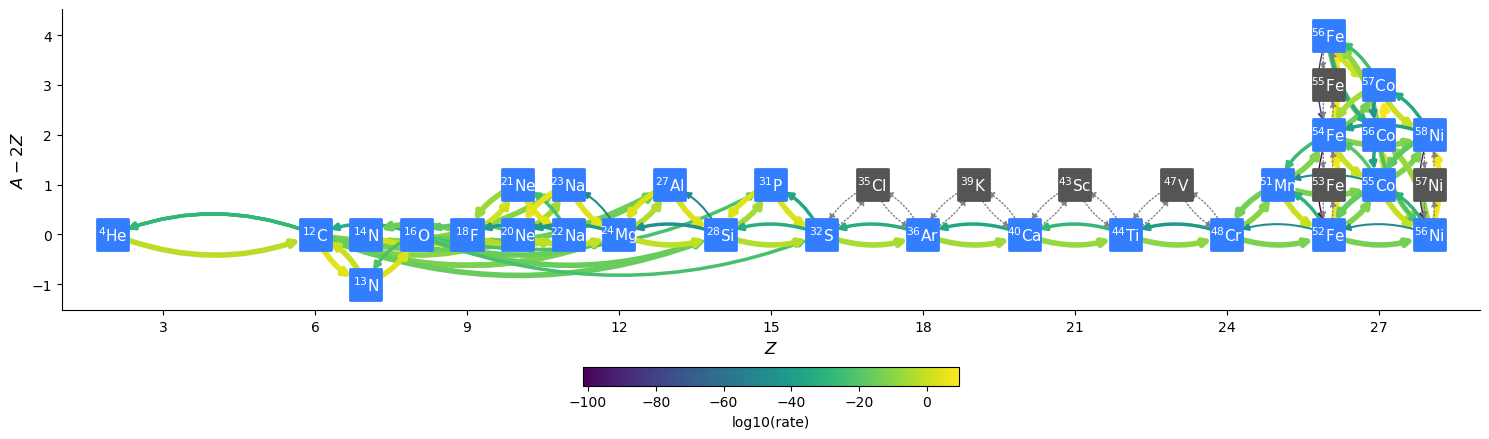

In [16]:
comp = pyna.Composition(net.get_nuclei())
comp.set_all(0.1)
comp.set_nuc("he4", 0.95)
comp.normalize()

rho = 1.e6
T = 1.e9

fig = net.plot(rho, T, comp, outfile="subch_simple.png",
               rotated=True, hide_xalpha=True, curved_edges=True,
               size=(1500, 450),
               node_size=500, node_font_size=11, node_color="#337dff", node_shape="s",
               Z_range=(1,29))

At this point, we could write the network and use it in another code, depending on which network class we used for the construction.

## Test integration

## Validate